# 有限元算例稳态Navier-Stokles方程Newton方法求解
本节将引导您使用 FEALPy.CFD 完成 Navier-Stokes 方程的 Newton 方法的有限元求解，现定义如下数学模型：
$$\begin{cases} -\nu \Delta \boldsymbol{u} + (\boldsymbol{u} \cdot \nabla)\boldsymbol{u} + \nabla p = \boldsymbol{f} & \text{in } \Omega, \\ \nabla \cdot \boldsymbol{u} = 0 & \text{in } \Omega, \\ \boldsymbol{u} = 0 & \text{on } \partial \Omega, \end{cases}$$
$$\int_{\Omega} p \, dx = 0,$$
其中：
- $\boldsymbol{u}$ 表示速度场，
- $p$ 表示压力，
- $\nu$ 为运动粘性系数，
- $\boldsymbol f$为外力，
- $\Omega$为计算区域。

我们定义真解为
$$\boldsymbol u = (u_1, u_2) $$
$$ u_1 = 10x^2(x-1)^2 y (y-1) (2y-1), u2 = -10x(x-1)(2x-1)y^2(y-1)^2 $$
$$ p = 10(2x-1)(2y-1)$$

## 1.定义PDE类型

In [ ]:
from fealpy.decorator import cartesian
from fealpy.backend import backend_manager as bm
from fealpy.backend import TensorLike
from fealpy.mesher import BoxMesher2d

class Exp0001(BoxMesher2d): 
    def __init__(self, options: dict = {}):
        self.options = options
        self.box = [0.0, 1.0, 0.0, 1.0]
        self.eps = 1e-10
        self.mu = 1.0
        self.rho = 1.0
        super().__init__(box=self.box)
    
    @cartesian
    def velocity(self, p: TensorLike) -> TensorLike:
        x = p[..., 0]
        y = p[..., 1]
        result = bm.zeros(p.shape, dtype=bm.float64)
        result[..., 0] = 10 * x ** 2 * (x - 1) ** 2 * y * (y - 1) * (2 * y - 1)
        result[..., 1] = -10 * x * (x - 1) * (2 * x - 1) * y ** 2 * (y - 1) ** 2
        return result
    
    @cartesian
    def pressure(self, p: TensorLike) -> TensorLike:
        x = p[..., 0]
        y = p[..., 1]
        return 10 * (2 * x - 1) * (2 * y - 1)
    
    @cartesian
    def source(self, p: TensorLike) -> TensorLike:
        x = p[..., 0]
        y = p[..., 1]
        result = bm.zeros(p.shape, dtype=bm.float64)
        result[..., 0] = 10.0*x**2*y*(x - 1)**2*(y - 1)*(2*y - 1)*(10*x**2*y*(2*x - 2)*(y - 1)*(2*y - 1) + 20*x*y*(x - 1)**2*(y - 1)*(2*y - 1)) - 40.0*x**2*y*(x - 1)**2 - 20.0*x**2*y*(y - 1)*(2*y - 1) - 40.0*x**2*(x - 1)**2*(y - 1) - 20.0*x**2*(x - 1)**2*(2*y - 1) - 10.0*x*y**2*(x - 1)*(2*x - 1)*(y - 1)**2*(20*x**2*y*(x - 1)**2*(y - 1) + 10*x**2*y*(x - 1)**2*(2*y - 1) + 10*x**2*(x - 1)**2*(y - 1)*(2*y - 1)) - 40.0*x*y*(2*x - 2)*(y - 1)*(2*y - 1) - 20.0*y*(x - 1)**2*(y - 1)*(2*y - 1) + 40*y - 20   
        result[..., 1] = 10.0*x**2*y*(x - 1)**2*(y - 1)*(2*y - 1)*(-20*x*y**2*(x - 1)*(y - 1)**2 - 10*x*y**2*(2*x - 1)*(y - 1)**2 - 10*y**2*(x - 1)*(2*x - 1)*(y - 1)**2) - 10.0*x*y**2*(x - 1)*(2*x - 1)*(y - 1)**2*(-10*x*y**2*(x - 1)*(2*x - 1)*(2*y - 2) - 20*x*y*(x - 1)*(2*x - 1)*(y - 1)**2) + 20.0*x*y**2*(x - 1)*(2*x - 1) + 40.0*x*y**2*(y - 1)**2 + 40.0*x*y*(x - 1)*(2*x - 1)*(2*y - 2) + 20.0*x*(x - 1)*(2*x - 1)*(y - 1)**2 + 40*x + 40.0*y**2*(x - 1)*(y - 1)**2 + 20.0*y**2*(2*x - 1)*(y - 1)**2 - 20
        return result

    @cartesian
    def is_velocity_boundary(self, p: TensorLike) -> TensorLike:
        return None

    @cartesian
    def is_pressure_boundary(self, p: TensorLike) -> TensorLike:
        result = bm.zeros_like(p[..., 0], dtype=bm.bool)
        return result

    @cartesian
    def velocity_dirichlet(self, p: TensorLike) -> TensorLike:
        return self.velocity(p)
    
    @cartesian
    def pressure_dirichlet(self, p: TensorLike) -> TensorLike:
        return self.pressure(p)



## 2. 进行参数配置和初始化

设置后端

In [25]:
from fealpy.backend import backend_manager as bm

backend = 'numpy'
device = 'cpu'
bm.set_backend(backend)

导入日志工具

In [26]:
from fealpy.utils import timer
from fealpy import logger

logger.setLevel('WARNING')
tmr = timer()
next(tmr)

定义求解参数

In [27]:
tol = 1e-10
maxstep = 10
maxit = 4

定义误差存储矩阵

In [28]:
u_errorMatrix = bm.zeros((1, maxit), dtype=bm.float64)
p_errorMatrix = bm.zeros((1, maxit), dtype=bm.float64)

## 3.有限元求解

流程包含：

- 构建求解方程的equation以及求解方法fem

- 设置速度和压力的空间

- 组装刚度矩阵 $A$ 和载荷向量 $F$

- 处理Dirichlet边界条件

- 求解线性系统 $A u_h = F$

- 计算L2误差 $\|u - u_h\|_{L^2(\Omega)}$

- 网格均匀加密

In [29]:
from fealpy.cfd.equation.stationary_incompressible_ns import StationaryIncompressibleNS
from fealpy.cfd.simulation.fem.stationary_incompressible_ns import Newton
from fealpy.solver import spsolve

tol = 1e-10
maxstep = 10
pde = Exp0001()
equation = StationaryIncompressibleNS(pde)
mesh = pde.init_mesh['uniform_tri'](nx=4, ny=4)
fem = Newton(equation, mesh)
fem.set.uspace('Lagrange', p=2)
fem.set.pspace('Lagrange', p=1)

for i in range(maxit):
    uh0 = fem.uspace.function()
    ph0 = fem.pspace.function()
    uh1 = fem.uspace.function()
    ph1 = fem.pspace.function()
    
    BForm  = fem.BForm()
    LForm  = fem.LForm()
    ugdof = fem.uspace.number_of_global_dofs()
    for _ in range(maxstep): 
        fem.update(uh0)
        A = BForm.assembly()
        b = LForm.assembly()

        A, b = fem.apply_bc(A, b, pde)
        A, b = fem.lagrange_multiplier(A, b)

        x = spsolve(A, b, 'mumps')
        uh1[:] = x[:ugdof]
        ph1[:] = x[ugdof:-1]
        res_u = mesh.error(uh0, uh1)
        res_p = mesh.error(ph0, ph1)
        if res_u + res_p < tol:
            print(f"Converged at iteration {i+1}")
            print("res_u =", res_u)
            print("res_p =", res_p)
            break
        uh0[:] = uh1
        ph0[:] = ph1
    u_errorMatrix[0, i] = mesh.error(uh1, pde.velocity)
    p_errorMatrix[0, i] = mesh.error(ph1, pde.pressure)
    if i < maxit - 1:
        mesh.uniform_refine()
        fem.update_mesh(mesh)


Converged at iteration 1
res_u = 1.3146039622176547e-13
res_p = 1.4156143171476716e-11
Converged at iteration 2
res_u = 4.319031273287281e-14
res_p = 8.977406618855806e-12
Converged at iteration 3
res_u = 2.3586081374030938e-14
res_p = 1.0132543007077954e-11
Converged at iteration 4
res_u = 2.4081230647802667e-14
res_p = 1.0199986117324947e-11


## 4.误差分析和收敛阶计算

In [30]:
next(tmr)
print("速度最终误差",u_errorMatrix)
print("order : ", bm.log2(u_errorMatrix[0,:-1]/u_errorMatrix[0,1:]))
print("压力最终误差",p_errorMatrix)  
print("order : ", bm.log2(p_errorMatrix[0,:-1]/p_errorMatrix[0,1:]))


Timer received None and paused.
   ID       Time        Proportion(%)    Label
-------------------------------------------------
速度最终误差 [[1.87952236e-03 2.05935706e-04 2.32700663e-05 2.80719074e-06]]
order :  [3.19010018 3.14564677 3.05127632]
压力最终误差 [[0.1625292  0.04039637 0.01008773 0.00252153]]
order :  [2.00840133 2.00162386 2.00022969]


## 5.结果可视化
在单元重心处计算真解和数值解，并进行可视化比较

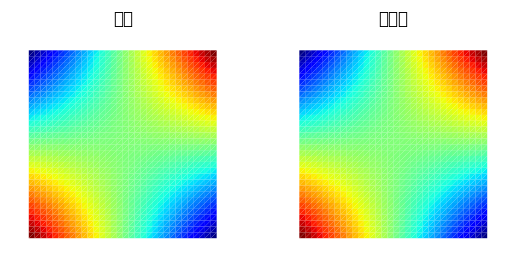

In [31]:
from matplotlib import pyplot as plt

bc = bm.array([[1/3, 1/3, 1/3]], dtype=bm.float64)
ps = mesh.bc_to_point(bc)
p = pde.pressure(ps)
ph = ph1(bc)

fig, axes = plt.subplots(1, 2)
mesh.add_plot(axes[0], cellcolor=p, linewidths=0)
axes[0].set_title('真解')
mesh.add_plot(axes[1], cellcolor=ph, linewidths=0)
axes[1].set_title('数值解')
plt.show()
